In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from MuCoST.mucost import training_model
from MuCoST.utils import mclust
from MuCoST.config import set_arg
from scipy.sparse import csr_matrix

In [2]:
opt = set_arg()
arg = opt.parse_args(['--mode_his', 'noh'])
arg.n_domain=8
arg.temp=1
arg.radius=50
arg.latent_dim=30
arg

Namespace(seed=2023, latent_dim=30, epoch=1000, lr=0.001, weight_decay=0.0, log_step=10, drop_feat_p=0.2, flow='source_to_target', radius=50, hvg_n=3000, rknn=6, knn=6, n_domain=8, temp=1, n_refine=25, mode_his='noh', mode_rknn='rknn', e_attr=0.3, use_eattr=False, corr=0.5, cut_corr=False)

In [3]:
input_dir = os.path.join('Data/stereo-seq')
counts_file = os.path.join(input_dir, 'RNA_counts.tsv')
coor_file = os.path.join(input_dir, 'position.tsv')

In [4]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')

In [5]:
counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

In [6]:
coor_df.head()

x            y
label                            
Spot_1  12555.007833  6307.537859
Spot_2  12623.666667  6297.166667
Spot_3  12589.567164  6302.552239
Spot_4  12642.495050  6307.386139
Spot_5  13003.333333  6307.990991

In [7]:
adata = sc.AnnData(counts.T)
adata.X = csr_matrix(adata.X)
adata.var_names_make_unique()

In [8]:
coor_df = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obsm["spatial"] = coor_df.to_numpy()

In [9]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata

AnnData object with n_obs × n_vars = 19527 × 27106
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

(6002.432692307692, 12486.580128205129, 9908.545833333334, 15086.093055555555)

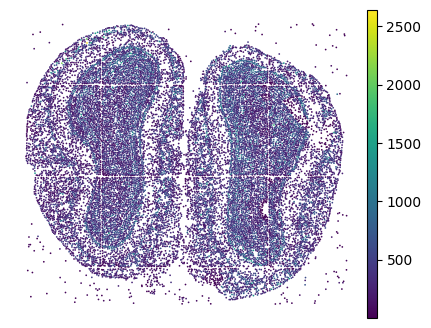

In [10]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [11]:
used_barcode = pd.read_csv(os.path.join('Data/stereo-seq/used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]

In [12]:
adata = adata[used_barcode,]

(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

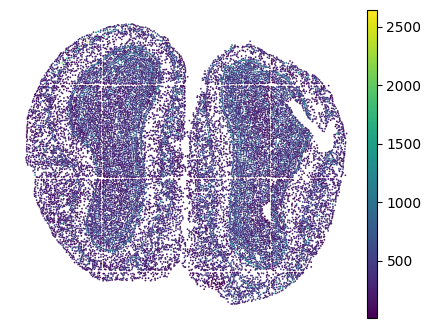

In [13]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [14]:
sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)

After flitering:  (19109, 14376)


/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Average spatial edge: 6.237898372494636
Average feature edge: 6.0


  0%|          | 0/1000 [00:00<?, ?it/s]

EP[ 100]: loss=2.5212.
EP[ 200]: loss=2.5157.
EP[ 300]: loss=2.5133.
EP[ 400]: loss=2.5128.
EP[ 500]: loss=2.5120.
EP[ 600]: loss=2.5113.
EP[ 700]: loss=2.5110.
EP[ 800]: loss=2.5104.
EP[ 900]: loss=2.5102.
EP[1000]: loss=2.5105.


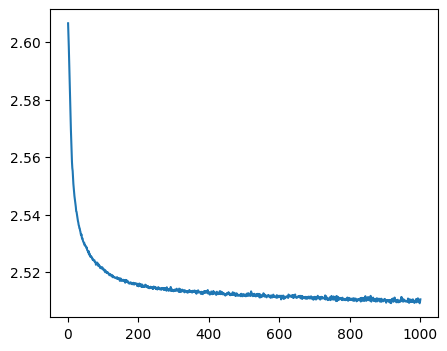

In [15]:
adata=training_model(adata, arg)

In [16]:
adata = mclust(adata, arg, refine=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [17]:
sc.pp.neighbors(adata, use_rep='MuCoST')
sc.tl.umap(adata)

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

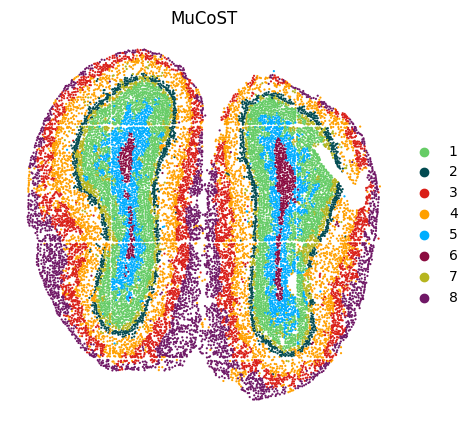

In [18]:
plot_color=["#66cc66","#024b51","#da1f18","#ffa000","#00aeff","#8a0c40","#b6b51f",
            "#701866","#f47a75","#8736c7"]
# plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
#              "#CD69C9","#EE7621","#B22222","#ACD700"]
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="mclust",s=10, palette=plot_color, show=False, title='MuCoST')
plt.axis('off')

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


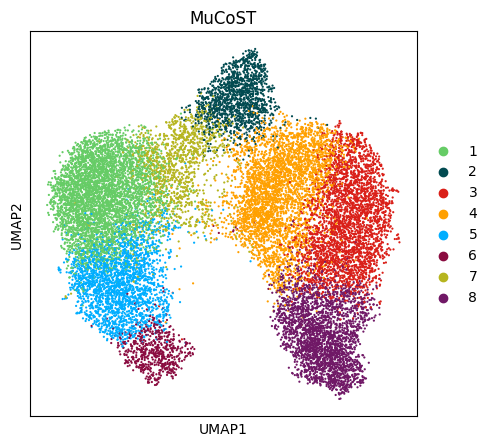

In [19]:
sc.pl.umap(adata, color='mclust',s=10, title='MuCoST')

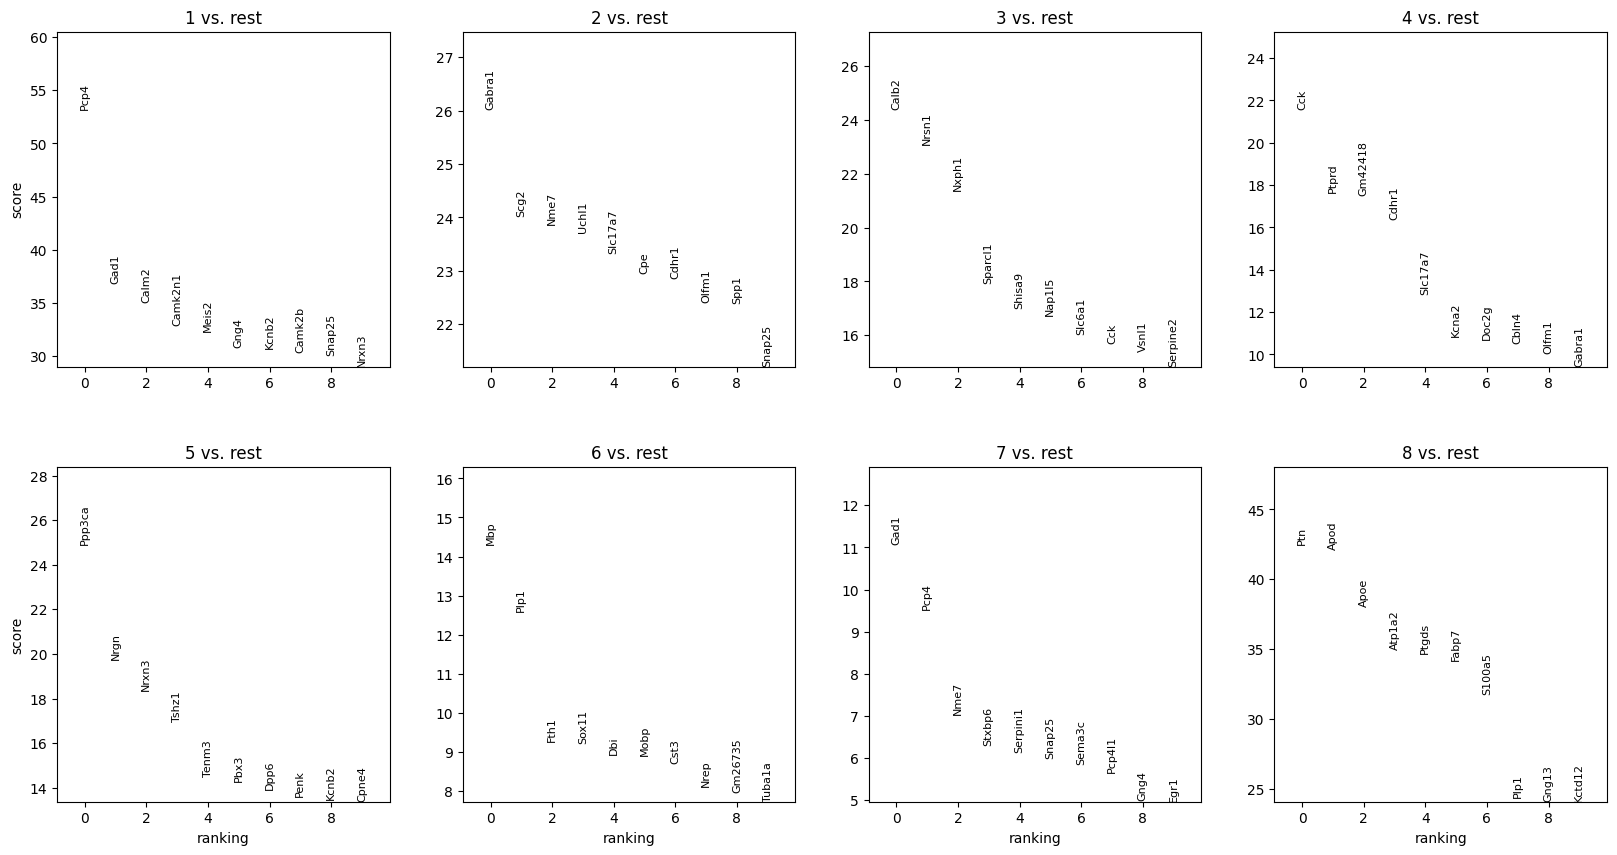

In [20]:
sc.tl.rank_genes_groups(adata, 'mclust', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [21]:
adata

AnnData object with n_obs × n_vars = 19109 × 14376
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mclust'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'umap', 'mclust_colors', 'rank_genes_groups'
    obsm: 'spatial', 'raw_feature', 'MuCoST', 'rec', 'emb_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

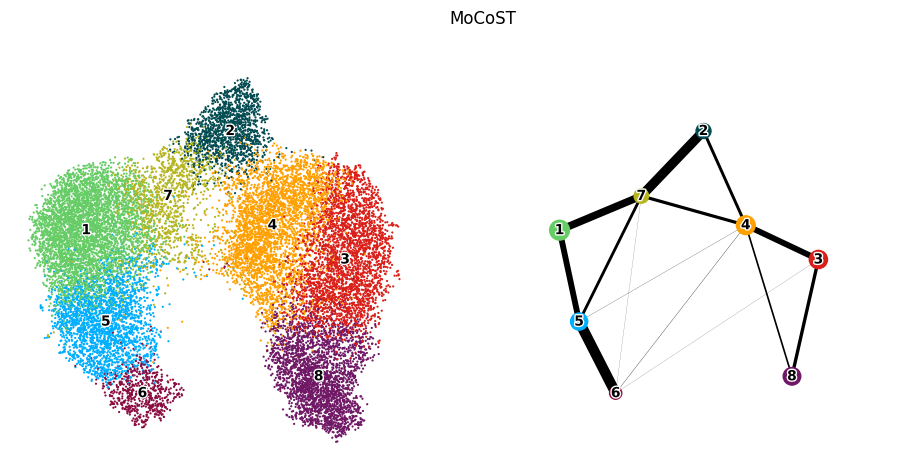

In [22]:
sc.tl.paga(adata,groups='mclust')
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.paga_compare(adata, legend_fontsize=10, frameon=False, size=10,
                   title='MoCoST', legend_fontoutline=2, show=False)

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


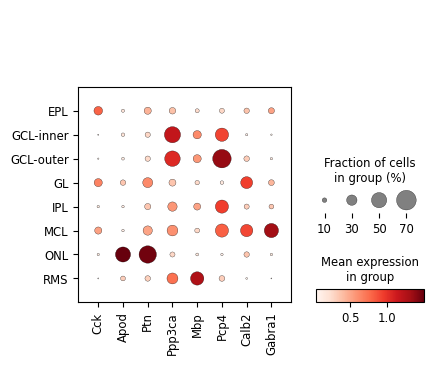

In [23]:
mark_genes = ['Cck','Apod','Ptn','Ppp3ca','Mbp','Pcp4','Calb2', 'Gabra1']
cluster_anno={'1':'GCL-outer','2':'MCL','3':'GL','4':'EPL','5':'GCL-inner','6':'RMS','7':'IPL','8':'ONL'}
adata.obs['domain_type']=adata.obs['mclust'].astype('str').map(cluster_anno)
sc.pl.dotplot(adata, mark_genes, groupby='domain_type',dendrogram=False)

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

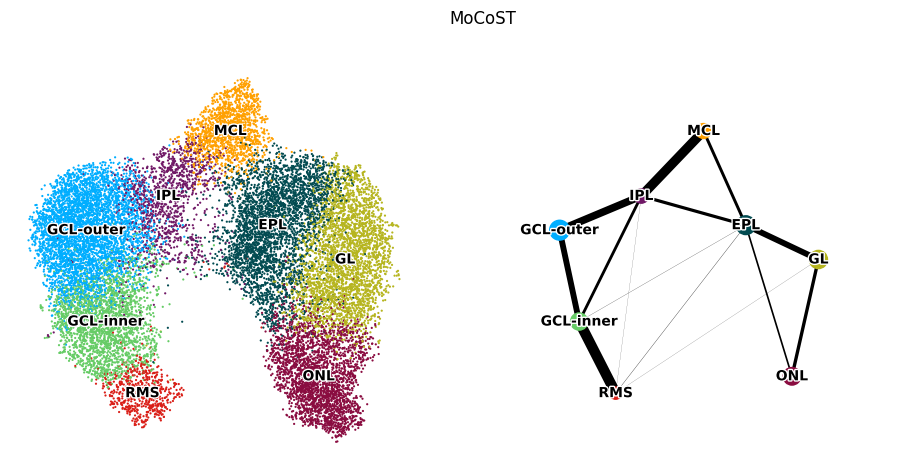

In [45]:
plot_color=["#024b51","#66cc66","#00aeff","#b6b51f","#701866","#ffa000","#8a0c40","#da1f18"]
cluster_anno={'1':'GCL-outer','2':'MCL','3':'GL','4':'EPL','5':'GCL-inner','6':'RMS','7':'IPL','8':'ONL'}
adata.obs['domain_type']=adata.obs['mclust'].astype('str').map(cluster_anno)
sc.tl.paga(adata,groups='domain_type')
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.paga_compare(adata, legend_fontsize=10, frameon=False, size=10,
                   title='MoCoST', legend_fontoutline=2, palette=plot_color,show=False)

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'MuCoST'}, xlabel='spatial1', ylabel='spatial2'>

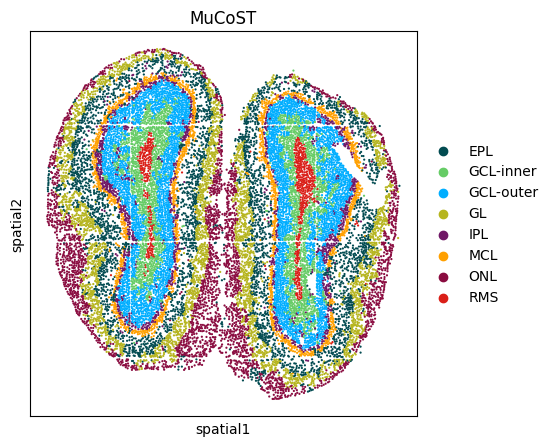

In [44]:
plot_color=["#024b51","#66cc66","#00aeff","#b6b51f","#701866","#ffa000","#8a0c40","#da1f18"]
sc.pl.embedding(adata, basis="spatial", color="domain_type",s=10,  palette=plot_color,show=False, title='MuCoST') #palette=plot_color,

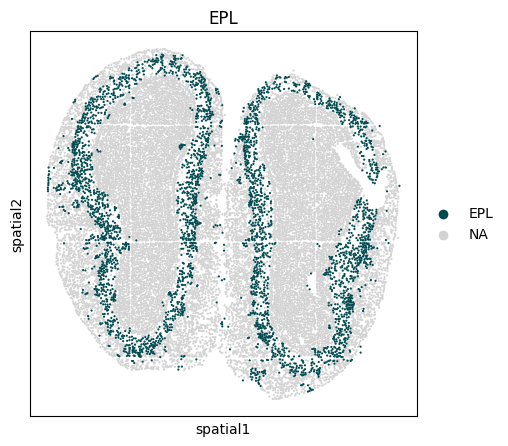

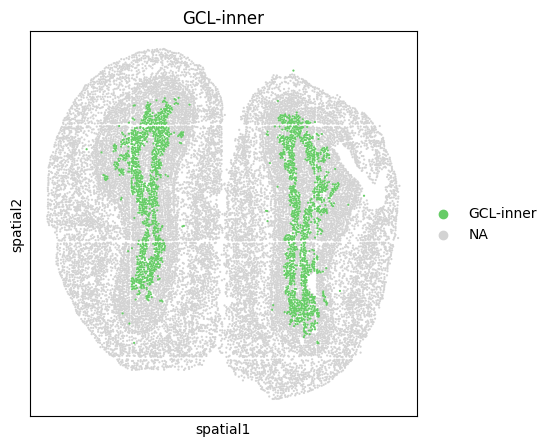

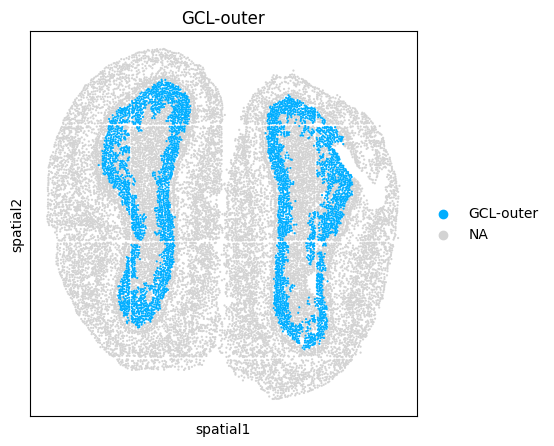

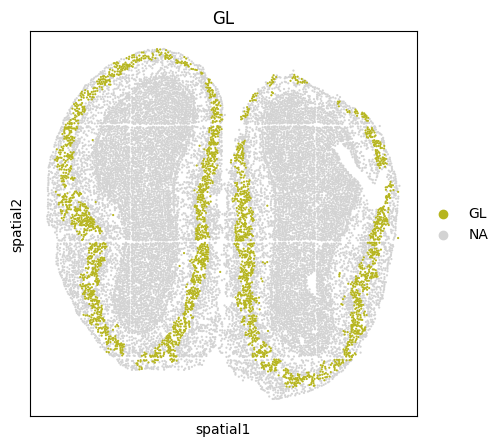

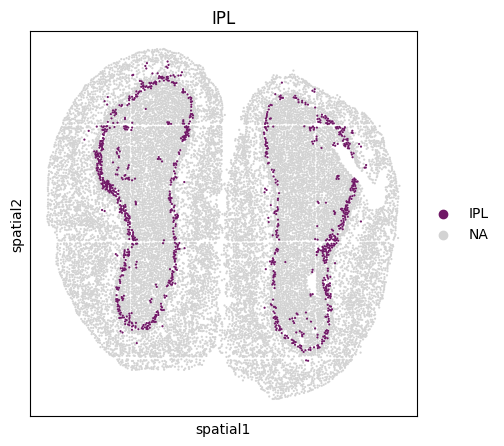

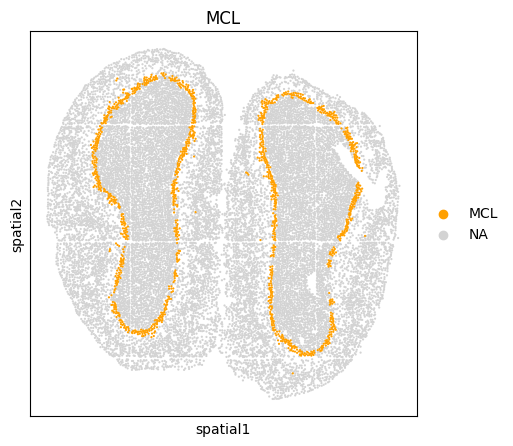

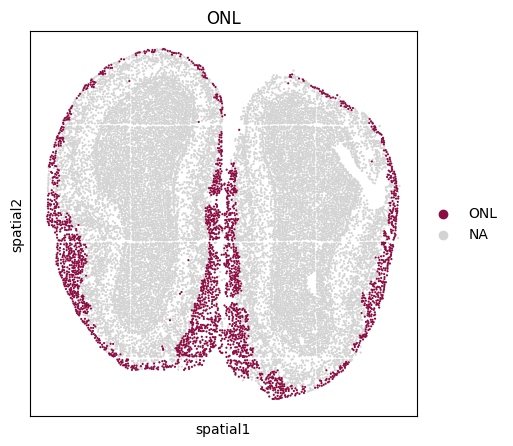

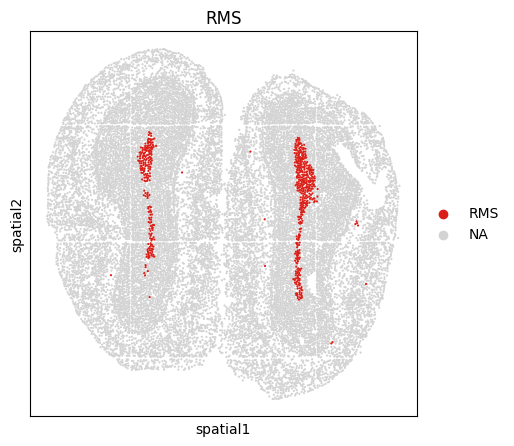

In [62]:
import warnings
warnings.filterwarnings("ignore")
plot_color=["#024b51","#66cc66","#00aeff","#b6b51f","#701866","#ffa000","#8a0c40","#da1f18"]
for i in adata.obs['domain_type'].cat.categories:
    sc.pl.embedding(adata, basis="spatial", color="domain_type",s=10, palette=plot_color, show=False, title=i, groups=i)

In [26]:
adata

AnnData object with n_obs × n_vars = 19109 × 14376
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mclust', 'domain_type'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'umap', 'mclust_colors', 'rank_genes_groups', 'paga', 'mclust_sizes', 'domain_type_sizes', 'domain_type_colors'
    obsm: 'spatial', 'raw_feature', 'MuCoST', 'rec', 'emb_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [58]:
adata.obs['domain_type'].cat.categories

Index(['EPL', 'GCL-inner', 'GCL-outer', 'GL', 'IPL', 'MCL', 'ONL', 'RMS'], dtype='object')

In [28]:
from sklearn.metrics import silhouette_score

# X为特征矩阵，labels为聚类结果的标签
silhouette_avg = silhouette_score(adata.obsm['MuCoST'], adata.obs['mclust'])
print("轮廓系数:", silhouette_avg)

轮廓系数: 0.12905052


In [63]:
(silhouette_avg+1)/2

0.564525231719017

In [29]:
from sklearn.metrics import calinski_harabasz_score

# X为特征矩阵，labels为聚类结果的标签
calinski_harabasz_score = calinski_harabasz_score(adata.obsm['MuCoST'], adata.obs['mclust'])
print("Calinski-Harabasz指数:", calinski_harabasz_score)

Calinski-Harabasz指数: 2901.826485590303


In [30]:
from sklearn.metrics import davies_bouldin_score

# X为特征矩阵，labels为聚类结果的标签
davies_bouldin_score = davies_bouldin_score(adata.obsm['MuCoST'], adata.obs['mclust'])
print("Davies-Bouldin指数:", davies_bouldin_score)

Davies-Bouldin指数: 2.1258994437351415


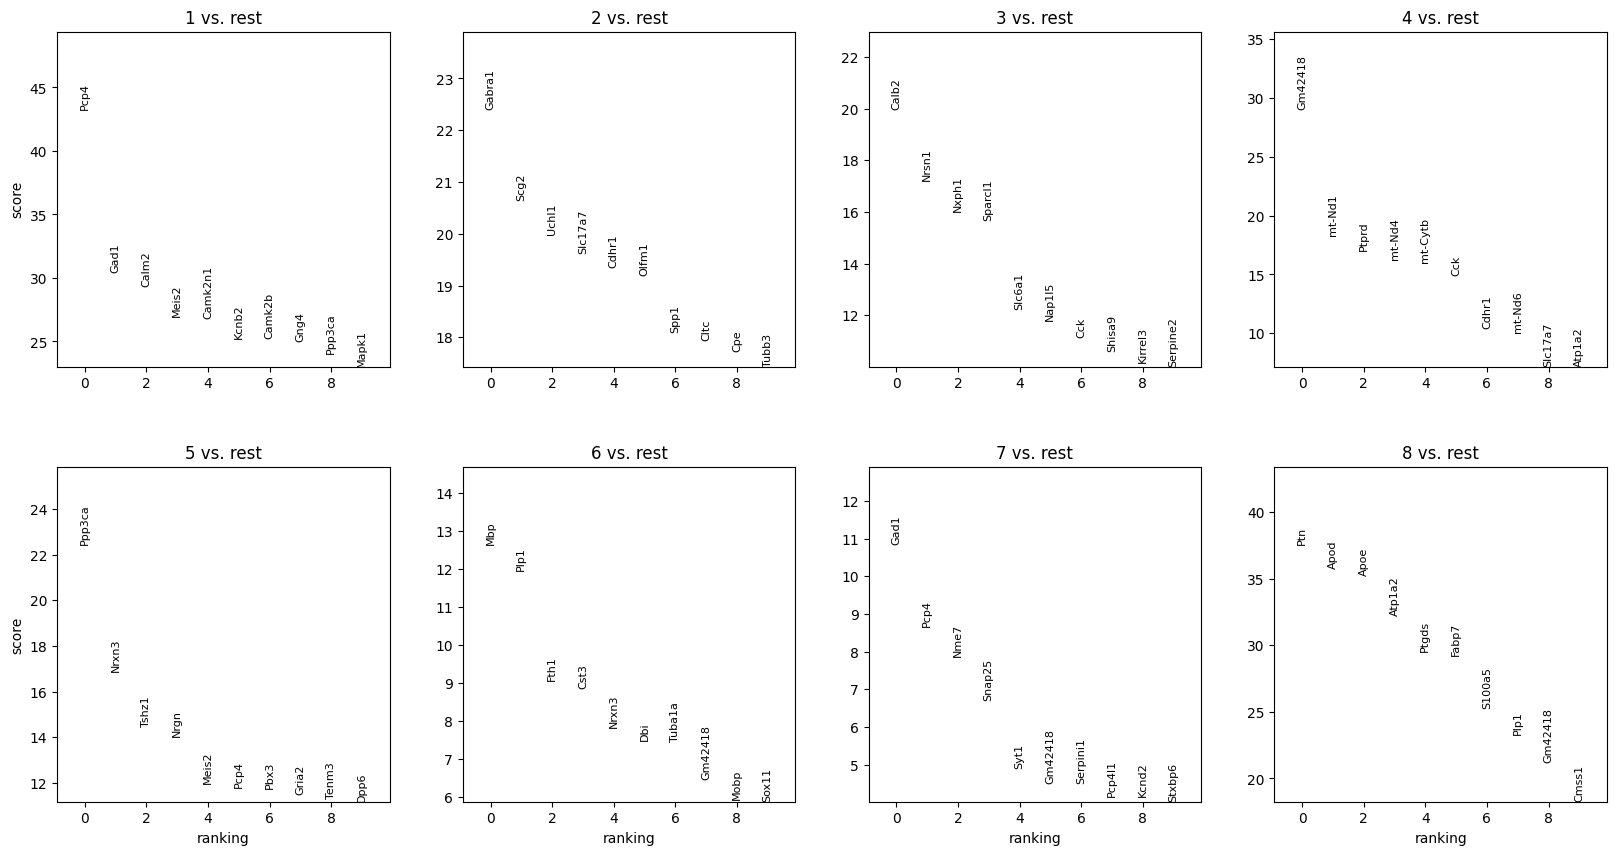

In [64]:
sc.tl.rank_genes_groups(adata, 'mclust', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

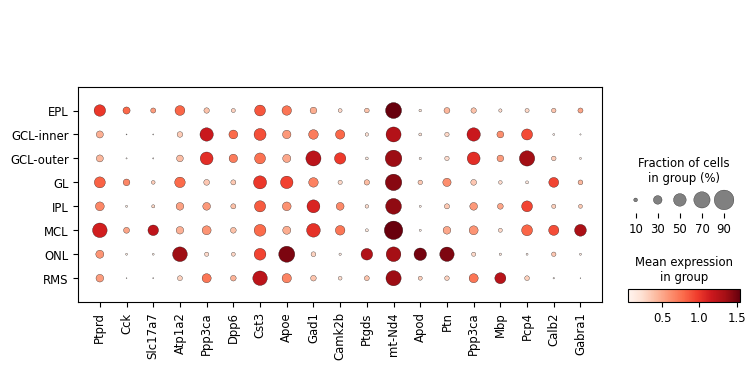

In [144]:
mark_genes = ['Ptprd','Cck','Slc17a7','Atp1a2',
              'Ppp3ca','Dpp6','Cst3','Apoe',
              'Gad1','Camk2b','Ptgds','mt-Nd4',
              'Apod','Ptn','Ppp3ca','Mbp','Pcp4','Calb2', 'Gabra1']
cluster_anno={'1':'GCL-outer','2':'MCL','3':'GL','4':'EPL','5':'GCL-inner','6':'RMS','7':'IPL','8':'ONL'}
adata.obs['domain_type']=adata.obs['mclust'].astype('str').map(cluster_anno)
sc.pl.dotplot(adata, mark_genes, groupby='domain_type',dendrogram=False)

<Axes: title={'center': 'Apod'}, xlabel='spatial1', ylabel='spatial2'>

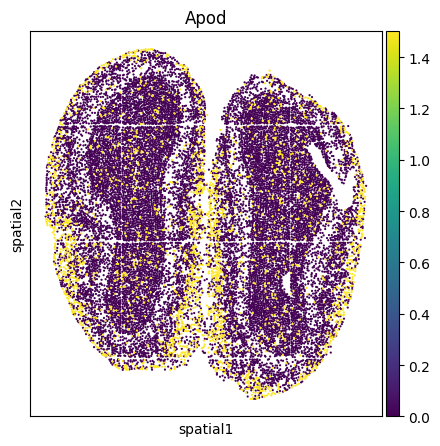

In [180]:
sc.pl.embedding(adata, basis="spatial", color='Apod', s=10, palette=plot_color, show=False,vmax=1.5)

Spot_1        8
Spot_10       8
Spot_100      8
Spot_1000     3
Spot_10000    8
             ..
Spot_9994     3
Spot_9995     8
Spot_9996     8
Spot_9998     8
Spot_9999     8
Name: mclust, Length: 19109, dtype: category
Categories (8, int64): [1, 2, 3, 4, 5, 6, 7, 8]


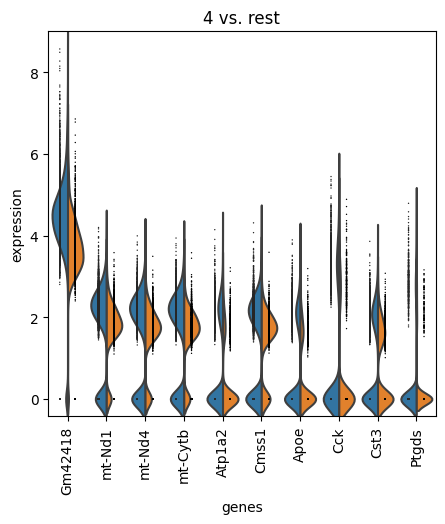

In [139]:

group = adata[(adata.obs['mclust']==2) | (adata.obs['mclust']==4)]
print(adata.obs['mclust'])
sc.tl.rank_genes_groups(group, 'mclust', method='wilcoxon')
sc.pl.rank_genes_groups_violin(group, groups=['4'], n_genes=10, jitter=False)